# Portfolio allocation based on ESG features

***
$\rightarrow$ **Definition of the project**

The research on sustainable finance has intensified in the past decade. ESG investing has gained a lot of traction and we end by asking if it drives stock performance.

On financial time series, we've concluded that the returns and the standardized residuals are defined as white noise, meaning that it's difficult to predict the future values of portfolio returns looking at past values. This postulate creates a mess up in student mind which are used to build a portfolio based on Markovitz theory.
We need to review our entire allocation strategy. 

* Can we build a model to predict the performance of a green stock return looking at its companies attributes (ESG score, Market capitalization, Price-to-Book ratio, 1 month volatility, ...)?
* Can we predict the companies that will outperform the crowd?
* Can we integrated Machine learning algorithms in trading system?
* What're the performance metrics of those strategies compared to a standard benchmark, an equally weighted portfolio?

In this report, we synthesize recent academic results and models on socially responsible investing (SRI) in equity markets. The aim of this project is to answer all these questions by creating and managing 3 portfolios with different strategies allocation: the CAC40 as a benchmark, a cap weighted portfolio and a Machine learning ESG allocation portfolio.

***

## Data preprocessing

The dataset consists of monthly financial information from February 28th, 2014 to February 26th, 2021 pertaining to 328 stocks around the globe. Each stock are characterized by their:

- Closing price (**Close**): Asset's price of a company at the last trading day of the month 
- Past 1 month volatility (**Vol_1M**): measure of dispersion of the returns of the company extracted from daily/weekly returns of the last month (expressed in percentage)
- Market capitalization in M$ (**Mkt_Cap**): is the market value of a publicly traded company's outstanding shares 
- Price-to-book ratio (**P2B**): is a ratio used to compare a company's current market value to its book value
- Debt-to-equity (**D2E**): is a ratio indicating the relative proportion of shareholders' equity and debt used to finance a company's assets
- ESG score (**ESG_rank**): is an ESG ranking from *Sustainalytics* 

In [1]:
                                                        # Install library xgboost and missingno
#!pip install xgboost                                    
#!pip install missingno       

import pandas as pd                                     # Data manipulation and analysis
import numpy as np                                      # Operate mathematical functions multi-dimensional 
import xgboost as xgb                                   # Boosted trees regression
import matplotlib.pyplot as plt                         # Creating static, animated, and interactive visualizations
import missingno as msno                                # Handle missing variables
import statsmodels.api as sm                            # Estimation of different statistical models (regression analysis)
import seaborn as sns                                   # Data visualization
import yfinance as yf                                   # Import Yahoo finance Tickers data (Close, Volume, ...)

from sklearn.preprocessing import StandardScaler        # Scale data with 0 mean and 1 standard deviation
from sklearn.pipeline import make_pipeline              # Construct a Pipeline from the given estimators 
from sklearn.linear_model import SGDRegressor           # SGDRegressor 
from sklearn.metrics import r2_score                    # Evaluate the prediction performance of the OLS regression model
from xgboost import XGBRegressor                        # XGBoosted regression
from sklearn.model_selection import cross_val_score     # Evaluate the model
from sklearn.model_selection import RepeatedKFold       # Controls the randomness of each repeated cross-validation

In [2]:
data_esg = pd.read_csv('data_esg.csv')                   # Read the CSV file
data_esg.set_index("Date", inplace = True)               # Set Date column as index
data_esg.head()                                          # Display first rows

,Tick,Close,Vol_1M,Mkt_Cap,P2B,D2E,ESG_rank
Date,,,,,,,
28/02/2014,A,38.1199,36.355,19014.6200,2.3387,49.4768,88.5057
31/03/2014,A,37.4436,20.190,18644.8762,2.2972,49.4768,88.5057
30/04/2014,A,36.2724,20.976,18018.0456,2.1469,47.8415,88.5057
30/05/2014,A,38.2189,17.087,18984.9651,2.2622,47.8415,87.6404
30/06/2014,A,38.6427,13.029,19142.5058,2.2872,47.8415,87.2093


### Missing data & imputation

The first step of the study is to process the data. This step is **crucial in portfolio building with machine learning**. We need to check if the dataset contains missing points and handle it in a efficient way.

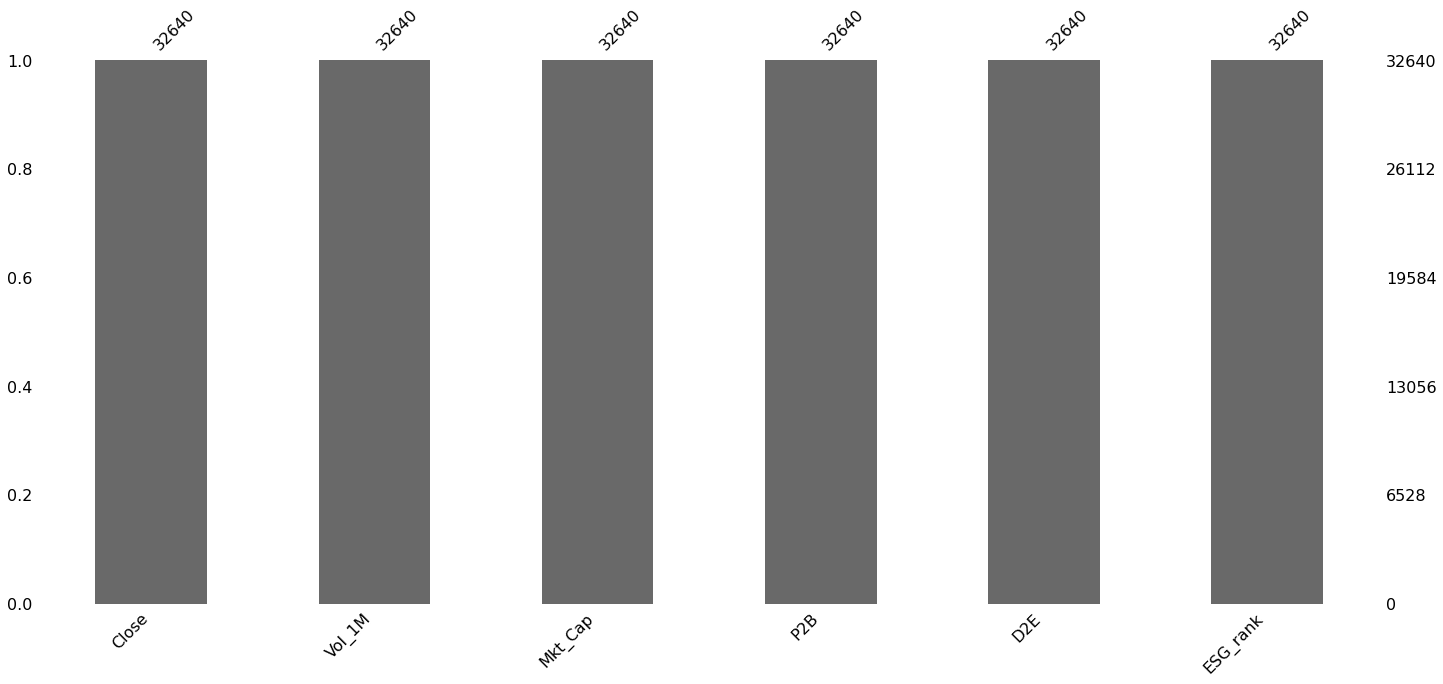

In [3]:
msno.bar(data_esg.iloc[:,1:]);                            # Check for missing data

There's no missing point in the dataset, we can move further to the engineering feature.

In [4]:
data_esg.iloc[:,:-1].describe()                                     # Statistics of features columns

,Close,Vol_1M,Mkt_Cap,P2B,D2E
count,32640.000000,32640.000000,3.264000e+04,32640.000000,32640.000000
mean,86.496838,27.059867,4.691767e+04,5.024023,124.191911
std,111.535558,17.461444,9.535007e+04,24.261446,204.607540
min,1.627500,1.775000,7.955008e+02,0.215700,0.000000
25%,37.985875,16.976750,1.131557e+04,1.663000,41.427575
50%,60.661350,22.807500,2.093507e+04,2.780600,77.971450
75%,100.075025,31.231500,4.356290e+04,5.005175,131.317200
max,3450.960000,296.520000,2.255969e+06,2256.900000,5926.069000


The **descriptive statistics** of the features highlights a dispersion between the median and both the minimum and maximum (presence of outliers?). For instance, the maximum **P2B** is $75*10^3$ times the median: this is a very huge number. The same observation holds for **D2E**. If these values an errors or due to very small values in the denominator? A low Equity compared to Debt or a low book value compared to market value. Also, there's a huge discrepancies between them, Mkt_Cap $10^6$, Vol_1M $10^2$, D2E and P2B $10^3$. 

So, we have to rescale the predictors (features) to the ESG range. We choose to work with positive values, but this is without much loss of generality. We scale the 4 variables with the **min-max rescaling**: $\tilde{x_i}=\frac{x_i-min(x)}{max(x)-min(x)}$. It's used to make the model training less sensitive to the scale of features and allows it to converge to better weights.

In [5]:
#Compute stock Forward return and takeout missing data
liste = [data_esg[data_esg['Tick'] == i]['Close'].shift(-1) / data_esg[data_esg['Tick'] == i]['Close'] - 1 
         for i in data_esg['Tick'].unique()]

data_esg['F_return'] = [liste[i][j] for i in range(len(liste)) for j in range(len(liste[i]))]
data_esg.dropna(inplace = True)

data_esg.drop(columns = ['Close'], inplace = True)                                   # Drop unnecessary column

In [6]:
data_esg_normal = pd.DataFrame(columns = ['Tick', 'Vol_1M', 'Mkt_Cap', 'P2B', 'D2E','Date']) # Create new dataframe
features = ['Vol_1M', 'Mkt_Cap', 'P2B', 'D2E']                                       # Predictors

for index in data_esg.index.unique() :
    X = data_esg.loc[index][features].reset_index(drop = True)                       # Copy the data at each date
    X_norm = 100 * (X - X.min(axis = 0))/(X.max(axis = 0) - X.min(axis = 0))         # Scaled values at each column
    X_norm = pd.DataFrame(X_norm,columns = ['Vol_1M', 'Mkt_Cap', 'P2B', 'D2E'])      # Rename columns
    X_norm['Date'] = index                                                           # fill Date
    X_norm['Tick'] = pd.DataFrame(data_esg.Tick.unique())                            # fill Tick
    data_esg_normal = data_esg_normal.append(X_norm)                                 # Append the dataframe
data_esg_normal.sort_values(by = ['Date','Tick'], inplace = True)                    # Sort dataframe as the initial one

# Add Tick and Vol_1M and ESG_rank columns
data_esg_normal['ESG_rank'] = data_esg.reset_index().sort_values(by = ['Date','Tick'])['ESG_rank'].values
data_esg_normal['F_return'] = data_esg.reset_index().sort_values(by = ['Date','Tick'])['F_return'].values

# Set Date as date format and sort by Tick and Date
data_esg_normal.Date = pd.to_datetime(data_esg_normal.Date)                
data_esg_normal = data_esg_normal.set_index("Date").sort_values(by = ['Tick', 'Date'])   

In [7]:
data_esg_normal

,Tick,Vol_1M,Mkt_Cap,P2B,D2E,ESG_rank,F_return
Date,,,,,,,
2014-02-28,A,48.096898,3.230435,0.124164,3.072605,88.5057,-0.017741
2014-03-31,A,35.182877,3.071057,0.092001,1.022726,88.5057,-0.031279
2014-04-30,A,21.550388,2.759700,0.079335,0.988923,88.5057,0.053663
2014-05-30,A,17.847185,2.728310,0.080883,0.988923,87.6404,0.011089
2014-06-30,A,6.454689,2.662557,2.943416,3.185297,87.2093,-0.023502
...,...,...,...,...,...,...,...
2020-09-30,ZTS,24.687324,3.917895,8.759663,6.517310,37.1179,-0.040041
2020-10-30,ZTS,15.980770,4.016374,10.216243,6.517310,36.4407,0.011542
2020-11-30,ZTS,17.254963,3.694742,9.394631,7.781975,39.7436,0.031924


#### &#8594; Plot distribution of the data

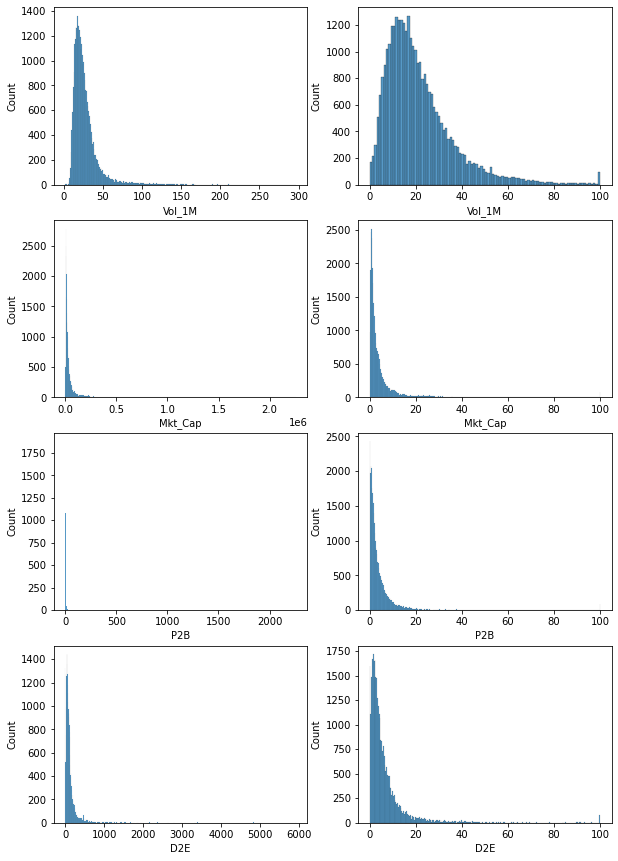

In [8]:
fig, ax = plt.subplots(4, 2, figsize = (10, 15))

for i in features:                                                   # Plot the density function of initial and scaled data
    sns.histplot(data_esg[i], ax = ax[features.index(i), 0])
    sns.histplot(data_esg_normal[i], ax = ax[features.index(i), 1]);

In [9]:
data_esg_normal.describe()

,Vol_1M,Mkt_Cap,P2B,D2E,ESG_rank,F_return
count,32256.000000,32256.000000,32256.000000,32256.000000,32256.000000,32256.000000
mean,21.536253,5.198273,4.383443,6.833287,52.925865,0.011041
std,15.050129,10.056269,8.105303,10.190901,25.006033,0.084240
min,0.000000,0.000000,0.000000,0.000000,0.000000,-0.832261
25%,11.252332,0.981528,0.923069,1.918805,33.333300,-0.032077
50%,17.995672,2.086956,2.201112,3.923819,54.386000,0.011365
75%,27.598382,4.807702,4.823552,7.695414,73.174350,0.053391
max,100.000000,100.000000,100.000000,100.000000,100.000000,2.138416


The distribution of the variables is highly affected by the scaling choice. We can observe that P2B and D2E are highly concentrate around smaller values (due to outliers?) and then have a certain impact on the regression. Although, we still keep it because its particular behavior can explained some patterns observed in the forecasting process. For the rest of the features the scaling seems ok.

## Machine Learning and portfolio allocation

By definition, a portfolio is a choice of weights that sum to one. To assess realistic strategies, we'll implement three classical portfolio, all based on different strategies most encountered in hedge funds. The weighting scheme follows signals led either by past returns or companies features. Our strategies are the following:

* The CAC40 as standard benchmark index
* The second one also serves as benchmark is sustainalytics oriented: with the 328 stock of our dataset where ESG rank are provided. Those two benchmarks will help to evaluate the pertinence of our strategy and the gap with market when investors are concerns by sustainable investing.
* **XGBoosted trees**: We first screen among all companies, the stocks which are more concerned by the global footprint on their activity, which is reflected in a relative ESG rank above the threshold of 50%.

In [10]:
# Split dataset into training and test data
X = data_esg_normal.copy().reset_index()
X.Date = pd.to_datetime(X.Date)
X_train = X.loc[X["Date"] <= "2019-1-31"]
X_test = X.loc[X["Date"] > "2019-1-31"]

X_train = X_train.set_index("Date").sort_values(by = ['Tick', 'Date'])   
X_test = X_test.set_index("Date").sort_values(by = ['Tick', 'Date'])   

Y_train = X_train.F_return                                   # Prediction in training sample
Y_test = X_test.F_return                                     # Prediction in testing sample

X_train.drop(columns = ['Tick', 'F_return'], inplace = True) # Drop non predictors columns
X_test.drop(columns = ['Tick', 'F_return'], inplace = True)  # Drop non predictors columns

In [11]:
fit = sm.OLS(Y_train, sm.add_constant(X_train)).fit()        # Perform OLS regression
print(fit.summary())                                         # Print summary

                            OLS Regression Results                            
Dep. Variable:               F_return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.883
Date:                Sun, 20 Jun 2021   Prob (F-statistic):           0.000182
Time:                        00:48:15   Log-Likelihood:                 28735.
No. Observations:               23040   AIC:                        -5.746e+04
Df Residuals:                   23034   BIC:                        -5.741e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.001      4.917      0.0

With the training scaled dataset of 5 years over 300+ stocks, the regression highlights that the forward relative return can only statistically be explained by the D2E feature. Without enough points to train on, we can't draw a clear pattern of the pratical impact of the ESG score on the stock performance. 

### SGDRegressor Model

In [12]:
scaler = StandardScaler()
scaler.fit(X_train)                                     # Fitting model on training data
Xm_train = scaler.transform(X_train)                    # Transform training data
Xm_test = scaler.transform(X_test)                      # Apply same transformation to test data

In [13]:
est = make_pipeline(StandardScaler(), SGDRegressor())   # Estimate valeues with SGDregressor
est.fit(Xm_train,Y_train.values)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor())])

In [14]:
y_pred_train = est.predict(Xm_train)                     # Predictions based on data
score = np.absolute(r2_score(Y_train, y_pred_train))     # Training score
print('Score: score = {:.5f}' .format(score))

Score: score = 0.00085


The score of the SGDRegressor model is very low: 2.7 basis point, which means this model doesn't well fitted to the data. We'll switch to XGboosted trees.

### XGboosted trees

In [15]:
model = XGBRegressor()                                  # Initiate the model
model.fit(X_train, Y_train.values)                      # Fitted to training data

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [16]:
# define model evaluation method
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
# evaluate model
scores = cross_val_score(model, X_train, Y_train.values, scoring='neg_mean_absolute_error', cv = cv, n_jobs = -1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.5f (%.5f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.05328 (0.00098)


In [17]:
# evaluate model
scores = cross_val_score(model, X_test, Y_test, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.081 (0.002)


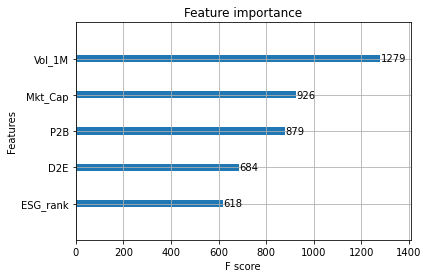

In [18]:
xgb.plot_importance(model);

The XGBoosted trees ended with a greater score compared to the regression model, meaning that we well fitted to data . The features plot enhances that the ESG rank is the last predictor in term of importance in the model, which is in line with the economic model observed over the study period. A few years ago, the ESG score was mostly used in risk analysis purposes as setting a minimum require level, better understand portfolio risk and how to improve things once they acquire. Recently, countries' regulators have made legal requirements for companies with their ESG and the correlation started to emerge. It’s a legitimate risk factor in the political space and efficiencies in operations. Since we're convinced that ESG drives returns to a degree, even if portfolios managers currently only use it for a secondary analysis. 

In [19]:
# Weighting the benchmark according to Mkt_Cap
data_esg['sum_Mkt_Cap'] = data_esg.groupby('Date').sum()['Mkt_Cap']           # Compute sum of Mkt_Cap
data_esg['Cap_weight'] = data_esg['Mkt_Cap'] / data_esg['sum_Mkt_Cap']        # Normalize it to sum 1 at each month
data_esg.drop(columns = 'sum_Mkt_Cap', inplace = True)                        # Drop sum column

# Compute the benchmark return 
data_esg['returns'] = data_esg['Cap_weight'] * data_esg['F_return']           # Compute asset returns in portfolio
data_esg['Portf_return'] = data_esg.groupby('Date')['returns'].sum()          # Sum monthly returns
data_esg.drop(columns = 'returns', inplace = True)                            # Drop returns column

In [20]:
# Weighting our portfolio according to ESG
data_esg['med_ESG'] = data_esg.groupby('Date')['ESG_rank'].median()
data_esg_cond = data_esg[data_esg['ESG_rank'] > data_esg['med_ESG']].copy()
data_esg_cond['Sum_cond_Mkt_Cap'] = data_esg_cond.groupby('Date')['Mkt_Cap'].sum()
data_esg_cond['Cap_cond_weight'] = data_esg_cond['Mkt_Cap'] / data_esg_cond['Sum_cond_Mkt_Cap']
data_esg_cond.drop(columns = ['Sum_cond_Mkt_Cap', 'med_ESG'], inplace = True)

# Compute the portfolio return
data_esg_cond['returns'] = data_esg_cond['Cap_cond_weight'] * data_esg_cond['F_return']
data_esg_cond['Portf_return'] = data_esg_cond.groupby('Date')['returns'].sum()
data_esg_cond.drop(columns = 'returns', inplace = True)

In [21]:
N = len(data_esg.index.unique())

# Compute the cumulative return of the benchmark
Benchmark = [1] + (1 + data_esg['Portf_return'].iloc[:N].values).tolist()
del Benchmark[-1]

Benchmark = pd.DataFrame(Benchmark, index = data_esg['Portf_return'].iloc[:N].index, columns = ['Benchmark'])
Benchmark = Benchmark.cumprod()

# Compute the cumulative return of the portfolio
Portf_return = [1] + (1 + data_esg_cond['Portf_return'].iloc[:N].values).tolist()
del Portf_return[-1]

Portf_return = pd.DataFrame(Portf_return, index = data_esg_cond['Portf_return'].iloc[:N].index, columns = ['Portf_return'])
Portf_return = Portf_return.cumprod()

# Merge all the data
plot_ret = pd.concat([Benchmark, Portf_return], axis = 1)

In [22]:
# Download data from Yahoo finance and compute forward return/cumulative return
CAC40 = yf.download(tickers = '^FCHI', start = '2014-02-28', end = '2021-02-28', interval = '1mo') 
CAC40['F_return'] = CAC40['Close'].shift(-1) / CAC40['Close'] - 1                            
CAC40.dropna(inplace = True)

CAC_ret = [1] + (1 + CAC40['F_return'].values).tolist()
CAC_ret = pd.DataFrame(CAC, index = data_esg_cond['Portf_return'].iloc[:N].index, columns = ['CAC40'])
CAC_ret = CAC_ret.cumprod()

# Merge all the data
plot_ret = pd.concat([Benchmark, Portf_return, CAC_ret], axis = 1)

[*********************100%***********************]  1 of 1 completed


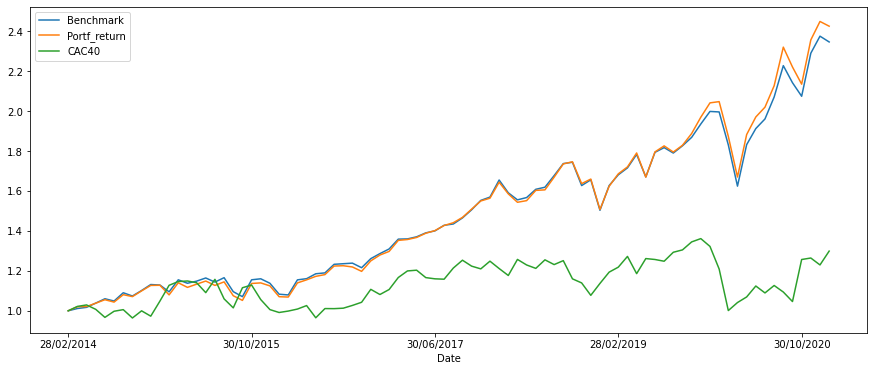

In [23]:
# Plot the evolution of strategies returns
fig, ax = plt.subplots(figsize = (15,6))
plot_ret.plot(ax = ax);

Starting with a simpler capitalization weighting scheme and a given threshold $\simeq 50$ in ESG rankings, we observe a sustainable return in the portfolio horizon compared to both benchmarks. A portfolio which consists of stock with high ESG will perform slightly better than the others. With no huge difference, the question of the allocation process emerges and we need to dig deeper and have a look at the screening / selection intensity with machine learning process in order to gain an additional return compared to a simpler cap weighted system.